# Decision Tree

## Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score 
import os

def image_path(fig_id):
    return os.path.join(".", fig_id)

## Read the data

In [2]:
#Load the dataset
song_data = pd.read_csv('https://raw.githubusercontent.com/yashapatel131/KDD_GroupProject/main/Datasets/Song_Attributes.csv')
song_data.head()

,ID,Acousticness,Album,Artist,Danceability,Duration,Energy,Explicit,Instrumentalness,Liveness,Loudness,Mode,Name,Popularity,popularityLabel,Speechiness,Tempo,TimeSignature,Valence
0,0,0.000728,Collective Soul (Deluxe Version),Collective Soul,0.520,234947,0.904,False,0.010300,0.0634,-5.030,1,Welcome All Again,35,Popular,0.0309,106.022,4,0.365
1,1,0.018200,Collective Soul (Deluxe Version),Collective Soul,0.581,239573,0.709,False,0.000664,0.1740,-4.909,1,Fuzzy,31,Popular,0.0282,120.027,4,0.408
2,2,0.000473,Collective Soul (Deluxe Version),Collective Soul,0.572,198400,0.918,False,0.000431,0.0977,-3.324,0,Dig,30,Popular,0.0559,144.061,4,0.370
3,3,0.000970,Collective Soul (Deluxe Version),Collective Soul,0.596,231453,0.661,False,0.000033,0.1130,-5.051,1,You,35,Popular,0.0254,111.975,4,0.183
4,4,0.000036,Collective Soul (Deluxe Version),Collective Soul,0.520,222520,0.808,False,0.000010,0.0800,-4.553,0,My Days,21,Popular,0.0318,92.721,4,0.666


In [3]:
#Drop some columns
songAttributes = song_data.drop(columns=['ID', 'Album', 'Mode', 'Name', 'Artist', 'Popularity'])
songAttributes.head()

,Acousticness,Danceability,Duration,Energy,Explicit,Instrumentalness,Liveness,Loudness,popularityLabel,Speechiness,Tempo,TimeSignature,Valence
0,0.000728,0.520,234947,0.904,False,0.010300,0.0634,-5.030,Popular,0.0309,106.022,4,0.365
1,0.018200,0.581,239573,0.709,False,0.000664,0.1740,-4.909,Popular,0.0282,120.027,4,0.408
2,0.000473,0.572,198400,0.918,False,0.000431,0.0977,-3.324,Popular,0.0559,144.061,4,0.370
3,0.000970,0.596,231453,0.661,False,0.000033,0.1130,-5.051,Popular,0.0254,111.975,4,0.183
4,0.000036,0.520,222520,0.808,False,0.000010,0.0800,-4.553,Popular,0.0318,92.721,4,0.666


In [4]:
#Dummy encoding and view the new columns
songAttributes_binary_encoded = pd.get_dummies(songAttributes, columns=['TimeSignature', 'Explicit'])
songAttributes_binary_encoded.columns

Index(['Acousticness', 'Danceability', 'Duration', 'Energy',
       'Instrumentalness', 'Liveness', 'Loudness', 'popularityLabel',
       'Speechiness', 'Tempo', 'Valence', 'TimeSignature_0', 'TimeSignature_1',
       'TimeSignature_3', 'TimeSignature_4', 'TimeSignature_5',
       'Explicit_False', 'Explicit_True'],
      dtype='object')

## Splitting the data

In [5]:
X = songAttributes_binary_encoded.drop(['popularityLabel', 'TimeSignature_1', 'Explicit_False'], axis=1)
y = songAttributes_binary_encoded['popularityLabel']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 6162)
X_train.head()

,Acousticness,Danceability,Duration,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo,Valence,TimeSignature_0,TimeSignature_3,TimeSignature_4,TimeSignature_5,Explicit_True
48090,0.11800,0.608,289173,0.312,0.000029,0.1030,-8.711,0.0263,93.034,0.223,0,1,0,0,0
30590,0.01210,0.381,490960,0.965,0.021800,0.9660,-3.676,0.1250,136.505,0.328,0,0,1,0,0
36643,0.10500,0.532,228587,0.466,0.000077,0.0737,-6.412,0.0279,159.956,0.430,0,1,0,0,0
137260,0.00304,0.582,567346,0.961,0.807000,0.0859,-10.149,0.0381,135.995,0.828,0,0,1,0,0
147494,0.37100,0.855,324189,0.694,0.000000,0.1090,-4.393,0.1690,122.078,0.490,0,0,1,0,1


## Identifying best depth

In [7]:
#Function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=4, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores

#Fitting trees of depth 3 to 24
sm_tree_depths = range(3,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)

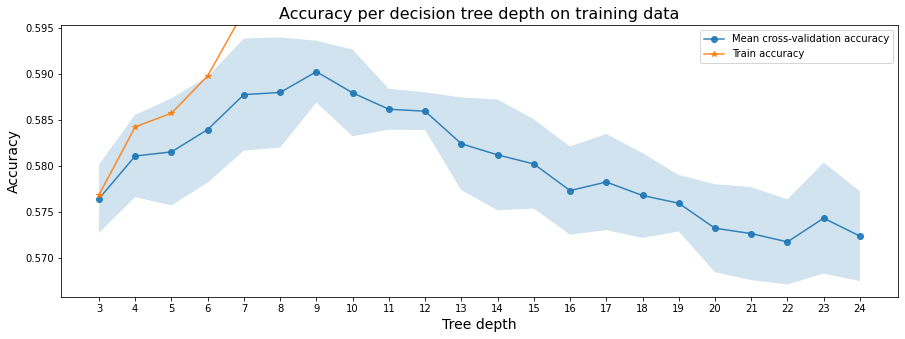

In [8]:
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='Mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='Train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

## Create and fit the model

In [9]:
#Get depth of best model
max_index = np.argmax(sm_cv_scores_mean)
maxdepth = sm_tree_depths[max_index]
sm_cv_scores_mean2 = np.delete(sm_cv_scores_mean, max_index)
max2_index = np.argmax(sm_cv_scores_mean2)
maxdepth2 = sm_tree_depths[max2_index]

In [10]:
#Model 1
tree = DecisionTreeClassifier(max_depth=maxdepth, random_state=6162)
tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=9, random_state=6162)

In [11]:
#Model 2
tree2 = DecisionTreeClassifier(max_depth=maxdepth2, random_state=6162)
tree2.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=8, random_state=6162)

## Visualize the Decision Tree

In [12]:
songAttributes_labels = songAttributes_binary_encoded.drop(['popularityLabel', 'TimeSignature_1', 'Explicit_False'], axis=1)

In [13]:
#Create the dot graph for the decision tree
export_graphviz(tree,
                out_file=image_path("Tree.dot"),
                feature_names=songAttributes_labels.columns,
                class_names=['Popular','Unpopular'],
                rounded=True,
                filled=True)

export_graphviz(tree2,
                out_file=image_path("Tree2.dot"),
                feature_names=songAttributes_labels.columns,
                class_names=['Popular','Unpopular'],
                rounded=True,
                filled=True)

#Convert the dot file to image on Anaconda prompt
#dot -Tpng dotname.dot -o imagename.png

Best Decision Tree
![title](Tree.png)

Second best Decision Tree
![title](Tree2.png)

## Evaluation of model

In [14]:
prediction_labels = tree.predict(X_test)
prediction_labels2 = tree2.predict(X_test)

In [15]:
print('Depth:', maxdepth2)
results2 = confusion_matrix(y_test, prediction_labels2)
print('Confusion Matrix:')
print(results2) 
print('Accuracy Score:', accuracy_score(y_test, prediction_labels2))
print('Report: ')
print(classification_report(y_test, prediction_labels2))

Depth: 8
Confusion Matrix:
[[ 9693 10753]
 [ 8414 17620]]
Accuracy Score: 0.5876290877796901
Report: 
              precision    recall  f1-score   support

     Popular       0.54      0.47      0.50     20446
   Unpopular       0.62      0.68      0.65     26034

    accuracy                           0.59     46480
   macro avg       0.58      0.58      0.58     46480
weighted avg       0.58      0.59      0.58     46480



In [16]:
print('Depth:', maxdepth)
results = confusion_matrix(y_test, prediction_labels)
print('Confusion Matrix:')
print(results) 
print('Accuracy Score:', accuracy_score(y_test, prediction_labels))
print('Report:')
print(classification_report(y_test, prediction_labels))

Depth: 9
Confusion Matrix:
[[10550  9896]
 [ 9112 16922]]
Accuracy Score: 0.5910499139414802
Report:
              precision    recall  f1-score   support

     Popular       0.54      0.52      0.53     20446
   Unpopular       0.63      0.65      0.64     26034

    accuracy                           0.59     46480
   macro avg       0.58      0.58      0.58     46480
weighted avg       0.59      0.59      0.59     46480

